In [10]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA,SparsePCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from IPython.display import HTML
import matplotlib.animation as animation
%matplotlib inline

In [11]:
from sklearn.manifold import TSNE
from umap import UMAP #pip install umap_learn

In [185]:
option_data = pd.read_csv('OptionData12110.csv',index_col=0)
option_data.head()

,Option_type,Ask,Bid,Option_price,Stock_price,Strike_price,Volatility,Volume,Time_to_maturity,Implied_volatility
0,1,0.20,0.0,0.09,79.54,45.0,0.286563,4,0.123288,0.763674
1,1,0.15,0.0,0.10,72.10,50.0,0.396490,1,0.095890,0.578129
2,1,0.30,0.0,0.05,82.05,55.0,0.273101,2,0.117808,0.568364
3,1,0.35,0.2,0.31,70.55,60.0,0.372803,2,0.082192,0.421881
4,1,0.90,0.7,0.85,70.55,65.0,0.372803,16,0.082192,0.363043


# Part I PCA, T-SNE, Umap transform data and visualize

In [894]:
#map to call vs put
call = option_data['Option_type']==0
put = option_data['Option_type']==1
#map to in-the-money vs out-of-the-money
itmCall = call & (option_data['Stock_price'] >= option_data['Strike_price'])
itmPut = put & (option_data['Stock_price'] <= option_data['Strike_price'])
itm = itmCall | itmPut
otm = ~itm
#drop option type, implied volatility
#cleanData = option_data.drop('Option_type',axis=1)
#cleanData.head()

In [537]:
#normalize data and transform dataset into PCA-space, return transformed dataset, pca object and scaler
def doPCA(data):
    #normalize
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(data)
    #init pca
    pca=PCA()
    newPCAData=pca.fit_transform(normalized_data)
    return newPCAData, pca, scaler

def doTSNE(data, perplexity=40, init='pca'):
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(data)
    tsne = TSNE(n_components=3,perplexity=perplexity, init=init)
    newData = tsne.fit_transform(normalized_data)
    return newData, tsne, scaler

def doUmap(data,init='random'):
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(data)
    umap = UMAP(n_components=3,n_neighbors=50,
                min_dist=0.15,
                metric='euclidean',
                init=init)
    newData = umap.fit_transform(normalized_data)
    return newData, umap, scaler

In [897]:
#scatter plot two classes in dataset
def biplot(newData, label_1, label_2, label_1_name, label_2_name, Method,figsize=(10,7)):
    fig = plt.figure(figsize=figsize)
    plt.scatter(newData[label_1,0],newData[label_1,1], label=label_1_name,
              marker='o', color='hotpink', edgecolors='b', alpha=0.5, s=50)
    plt.scatter(newData[label_2,0],newData[label_2,1], label=label_2_name,
              marker='o', color='r', edgecolors='g', alpha=0.5, s=50)    

    plt.legend()   
    ax=plt.gca()
    ax.legend(prop={'size':10})
    plt.xlabel(Method+'_1',fontsize=10)
    plt.ylabel(Method+'_2',fontsize=10)
    plt.title('Data plotted in '+Method+' space')
    return fig

#compare data embedded by PCA, T-SNE, and Umap
def compareplot(newData, label_1, label_2, label_1_name, label_2_name,figsize=(20,6)):
    fig, ax = plt.subplots(1,3,figsize=figsize)
    label = ['PCA','T-SNE','UMAP']
    for i in range(3):
        ax[i].scatter(newData[i][label_1,0],newData[i][label_1,1], label=label_1_name,
                    marker='o', color='olive', edgecolors='b', alpha=0.5, s=50)
        ax[i].scatter(newData[i][label_2,0],newData[i][label_2,1], label=label_2_name,
                  marker='o', color='peachpuff', edgecolors='g', alpha=0.5, s=50)    
        ax[i].set_xlabel(label[i]+'_1',fontsize=10)
        ax[i].set_ylabel(label[i]+'_2',fontsize=10)
        ax[i].legend(prop={'size':10})
        ax[i].set_title('Option Data Embedded via '+label[i])
    fig.savefig('Embedded Option Data groupby '+label_1_name)

#plot 3D PCA space, return anime object
def plot3D(newData, label_1, label_2, label_1_name, label_2_name, method):
    fig = plt.figure(figsize=(10,7))
    ax = Axes3D(fig)
    ax.set_title('Option Data Embedded via '+method)
    ax.set_xlabel(method+'$_{1}$')
    ax.set_ylabel(method+'$_{2}$')
    ax.set_zlabel(method+'$_{3}$')
    ax.scatter(newData[label_1,0], newData[label_1,1], newData[label_1,2], 
               label = label_1_name, color='teal',edgecolors='g', alpha=0.3, s=50)
    ax.scatter(newData[label_2,0], newData[label_2,1], newData[label_2,2], 
               label = label_2_name, color='goldenrod', edgecolors='w',alpha=0.3,s=50)
    ax.legend(loc=1)
    def init():
        plt.close(fig)
        return fig
    def animate(i):
        ax.view_init(elev=30., azim=3.6*i)
        return fig
    # Animate, blit=True: redraw obj.
    ani = animation.FuncAnimation(fig, animate,
                                    init_func=init, frames=100, interval=100)
    return ani

In [540]:
pca_data, pca, scaler = doPCA(option_data)
#take 5 min to run
tsne_data, tsne, scaler = doTSNE(option_data,perplexity=40) 
umap_data, umap, scaler = doUmap(option_data)

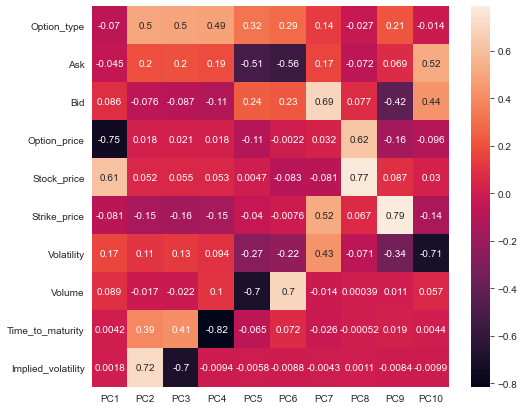

In [544]:
#visualize PCs
plt.figure(figsize=(8,7))
pca_df = pd.DataFrame(pca.components_,columns=['PC'+str(i) for i in range(1,option_data.shape[1]+1)],
                      index=option_data.columns)
sns.heatmap(pca_df,annot=True)

In [546]:
#first 6 components explained variance = 93.5%
#rank importance of features in first 5 PCs by weighted distance
print(np.cumsum(pca.explained_variance_ratio_))
first6PC = pca_df.iloc[:,:6].copy()
importance = (first6PC**2).apply(lambda x:x.dot(pca.explained_variance_[:6]),axis=1)
importance.sort_values(ascending=False,inplace=True)
importance

[0.35254828 0.53565402 0.64846061 0.75154685 0.84888597 0.93499013
 0.9859694  0.99389496 0.99984455 1.        ]


Option_price          2.008069
Implied_volatility    1.488318
Stock_price           1.342268
Option_type           1.179530
Time_to_maturity      1.168319
Volume                0.935892
Ask                   0.682929
Volatility            0.265186
Bid                   0.160151
Strike_price          0.120011
dtype: float64

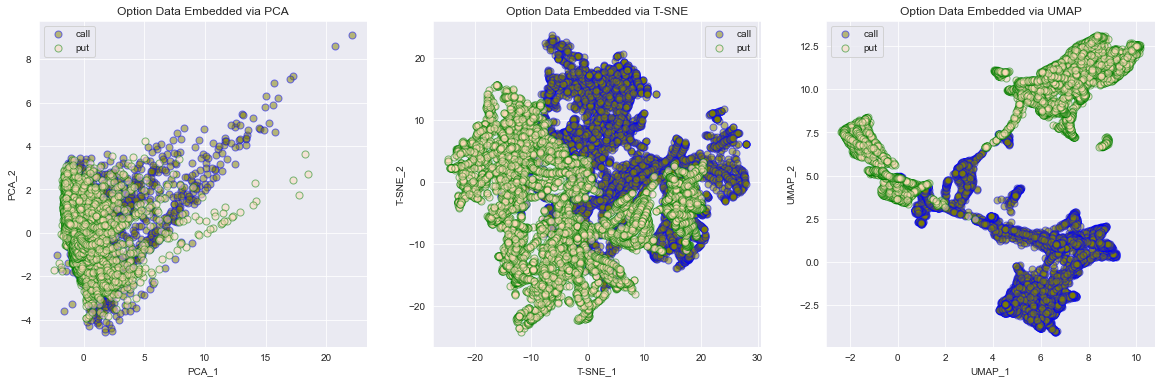

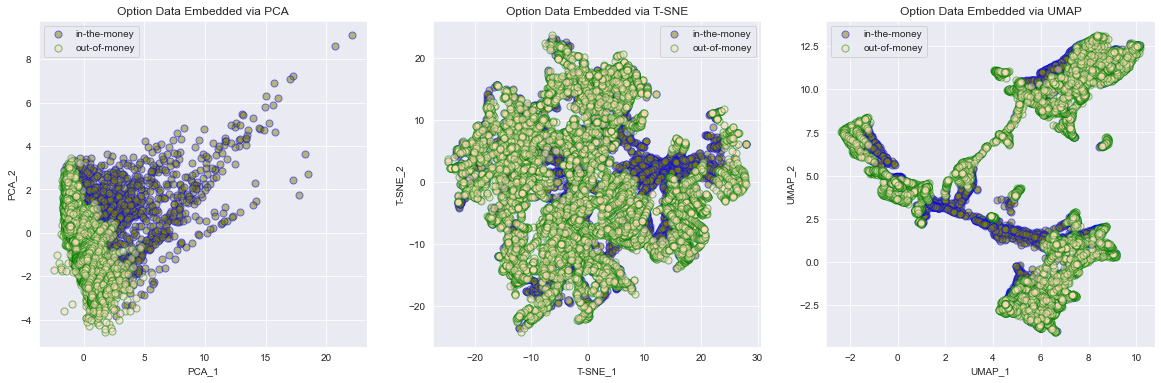

In [898]:
compareplot([pca_data,tsne_data,umap_data],call,put,'call','put')
compareplot([pca_data,tsne_data,umap_data],itm,otm,'in-the-money','out-of-money')

In [548]:
#3D plot call vs put, ITM vs OTM 
#ani1 = plot3D(pca_data,call,put,'call','put','PCA')
#ani2 = plot3D(pca_data,itm,otm,'in-the-money','out-of-money','PCA')
ani3 = plot3D(tsne_data,call,put,'call','put','T-SNE')
ani4 = plot3D(umap_data,call,put,'call','put','UMAP')
#require installation of ffmpeg
#https://ffmpeg.zeranoe.com/builds/
#HTML(ani1.to_html5_video())
#HTML(ani2.to_html5_video())

#ani1.save('pca_3d_1.mp4',writer='ffmpeg')
#ani2.save('pca_3d_2.mp4',writer='ffmpeg')
ani3.save('tsne_3d_1.mp4',writer='ffmpeg')
ani4.save('umap_3d_1.mp4',writer='ffmpeg')

# Par II Use DNN, k-NN, ExtraTree, GB to predict implied volatilities. Compute the MSE

In [179]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten
from scipy.stats import norm
from scipy.stats import kurtosis
from scipy.stats import skew
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

#### Preprocess and Split data, 80% for training, 20% for testing 

In [883]:
#split data and apply tuned model
x_train,x_test,y_train,y_test = train_test_split(option_data.drop('Implied_volatility',axis=1),
                                                option_data['Implied_volatility'],test_size=0.2,random_state=42)
#map to call vs put
call = x_test['Option_type']==0
put = x_test['Option_type']==1
#map to in-the-money vs out-of-the-money
itmCall = call & (x_test['Stock_price'] >= x_test['Strike_price'])
itmPut = put & (x_test['Stock_price'] <= x_test['Strike_price'])
itm = itmCall | itmPut
otm = ~itm


In [777]:
#standardize features except option type
#train_type = np.c_[x_train['Option_type']]
#test_type = np.c_[x_test['Option_type']]
scaler = StandardScaler()
#normed_x_train = np.concatenate([train_type,scaler.fit_transform(x_train.drop('Option_type',axis=1))],axis=1)
#normed_x_test = np.concatenate([test_type,scaler.transform(x_test.drop('Option_type',axis=1))],axis=1)
normed_x_train = scaler.fit_transform(x_train)
normed_x_test = scaler.transform(x_test)

# #transform data to other spaces
# pca_x_train,model_pca,scaler = doPCA(x_train.drop('Option_type',axis=1))
# pca_x_test = model_pca.transform(x_test.drop('Option_type',axis=1))
# pca_x_train,pca_x_test = pca_x_train[:,:6],pca_x_test[:,:6]
# #tsne_x_train,dnn_tsne,scaler = doTSNE(x_train)
# #tsne_x_test = dnn_tsne.transform(normed_x_test)
# umap_x_train,model_umap,scaler = doUmap(x_train.drop('Option_type',axis=1))
# umap_x_test = model_umap.transform(x_test.drop('Option_type',axis=1))

#### Use training set for cross validation to tune DNN

In [603]:
#tune batch size, activation function, optimizer
def create_DNN_model(activation='relu',optimizer='adam'):
    model = Sequential()
    model.add(Dense(128, activation=activation,input_shape=(x_train.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.add(Dropout(0.2))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

np.random.seed(42)
model = KerasClassifier(build_fn=create_DNN_model, epochs=200, verbose=0)
# define the grid search parameters
batch_size = [40, 60, 80, 100]
activation = ['softmax', 'relu', 'tanh', 'sigmoid']
optimizer = ['SGD', 'RMSprop', 'Adam', 'Adamax']
param_grid = dict(batch_size=batch_size,activation=activation,optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid,scoring='neg_mean_squared_error',
                    n_jobs=4, cv=5, verbose=1)
grid_result = grid.fit(normed_x_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  6.6min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 24.8min
[Parallel(n_jobs=4)]: Done 320 out of 320 | elapsed: 42.0min finished


In [606]:
grid_result.best_params_

{'activation': 'softmax', 'batch_size': 60, 'optimizer': 'Adamax'}

#### Test optimized DNN

In [821]:
#test optimized DNN
def testDNN(x_train,y_train,x_test,y_test,subset='Total'):
    model = Sequential()
    model.add(Dense(128, activation='tanh',input_shape=(x_train.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='Adamax', metrics=['mse'])
    history = model.fit(x_train,y_train,validation_data=(x_test,y_test),
                        batch_size=60,epochs=250,verbose=0)
    y_predict = model.predict(x_test)
    sq_err = (np.c_[y_test]-y_predict)**2 
    if subset =='Total':
        mse = pd.Series({'Total_MSE':np.mean(sq_err),'ITM_MSE':np.mean(sq_err[itm]),
                         'OTM_MSE':np.mean(sq_err[otm])})
    else:
        mse = pd.Series({subset:np.mean(sq_err)})
    return mse,history,y_predict

In [824]:
#DNN applied to normalized data
DNN_mse, DNN_history,DNN_y_predict = testDNN(normed_x_train,y_train,normed_x_test,y_test)
print('DNN MSE for normalized data: ',DNN_mse)

DNN MSE for normalized data:  Total_MSE    0.008186
ITM_MSE      0.010221
OTM_MSE      0.007126
dtype: float64


In [793]:
DNN_pca_mse,DNN_PCA_history = testDNN(pca_x_train,y_train,pca_x_test,y_test)
print('DNN MSE for PCAed data: ',DNN_pca_mse)

DNN MSE for PCAed data:  Total_MSE    0.097218
ITM_MSE      0.088805
OTM_MSE      0.101605
dtype: float64


In [794]:
DNN_umap_mse,DNN_UMAP_history = testDNN(umap_x_train,y_train,umap_x_test,y_test)
print('DNN MSE for UMAPed data: ',DNN_umap_mse)

DNN MSE for UMAPed data:  Total_MSE    0.049678
ITM_MSE      0.058011
OTM_MSE      0.045333
dtype: float64


In [795]:
def plotError(y_test,y_predict,history=None,method='sample'):
    if not history:
        fig, ax = plt.subplots(figsize=(6,5))
        ax.scatter(y_test[itm],y_predict[itm],c='k',s=5,label='itm')
        ax.scatter(y_test[otm],y_predict[otm],c='y',s=5,label='otm')
        ax.plot([0,1],[0,1],c='r')
        ax.set(xlabel='Actual y',ylabel='Predicted y')
        ax.set_title('Actual vs Predicted IV via {}'.format(method))
        ax.legend()
        fig.savefig('residual for '+method+'.png')
    else:
        fig, ax = plt.subplots(1,2,figsize=(14,5))
        ax[0].scatter(y_test[itm],y_predict[itm],c='k',s=5,label='itm')
        ax[0].scatter(y_test[otm],y_predict[otm],c='y',s=5,label='otm')
        ax[0].plot([0,1],[0,1],c='r')
        ax[0].set(xlabel='Actual y',ylabel='Predicted y')
        ax[0].set_title('Actual vs Predicted for {}'.format(method))
        ax[0].legend()
        ax[1].plot(history.history['val_loss'],'r',label='Test loss')
        ax[1].plot(history.history['loss'],'teal',label='Train loss')
        ax[1].set(xlabel='Epoch',ylabel='MSE')
        ax[1].set_title('MSE over training for {}'.format(method))
        ax[1].legend()
        fig.savefig('residual and mse for '+method+'.png')

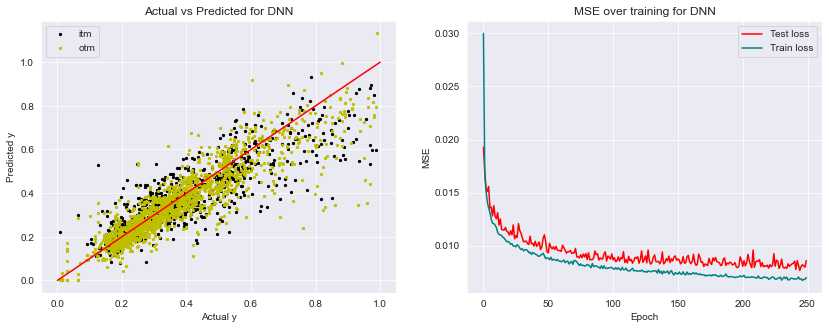

In [700]:
plotError(y_test,DNN_y_predict,DNN_history,'DNN')
#plotError(y_test,DNN_pca_y_predict,DNN_PCA_history,'PCA Emedded DNN')
#plotError(y_test,DNN_umap_y_predict,DNN_UMAP_history,'UMAP Embedded DNN')

In [718]:
#compare residuals between groups
def compare_residual(y_test,y_predict,label_1,label_2,label_1_name,label_2_name,method):
    all_ = ~(label_1 & label_2)
    groups= [all_,label_1,label_2]
    group_name = ['All',label_1_name,label_2_name]
    residual = np.c_[y_test]-np.c_[y_predict]
    
    sns.set_style("darkgrid")
    fig,axes= plt.subplots(1,3,figsize=(16,4))
    for i,ax in zip(range(3),axes):
        group = residual[groups[i]]
        mse = np.mean(group**2)
        sns.distplot(group,fit=norm,hist_kws={'edgecolor':'black'}, kde_kws={'color': 'm'},ax=ax)
        ax.set_title('{} residual plot for {}'.format(method,group_name[i]))
        ax.text(0.7,0.9,'Mean: {:.3f}'.format(np.mean(group)),transform=ax.transAxes)
        ax.text(0.7,0.85,'Std: {:.3f}'.format(np.std(group)),transform=ax.transAxes)
        ax.text(0.7,0.8,'Skewness: {:.3f}'.format(skew(group)[0]),transform=ax.transAxes)
        ax.text(0.7,0.75,'Kurtosis: {:.3f}'.format(kurtosis(group)[0]),transform=ax.transAxes)
        ax.text(0.7,0.7,'MSE: {:.5f}'.format(mse),transform=ax.transAxes)
    fig.savefig(method+' Residual Plot.png')

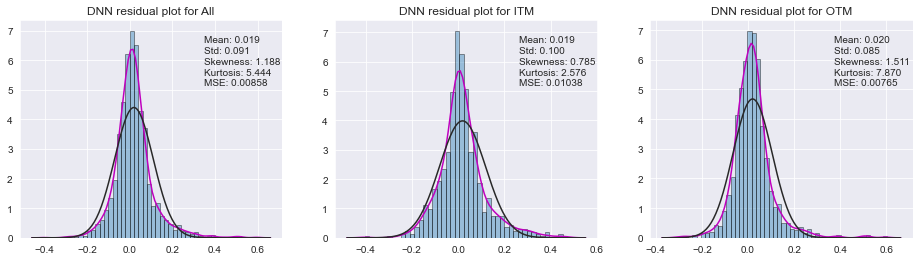

In [719]:
f = compare_residual(y_test,DNN_y_predict,itm,otm,'ITM','OTM','DNN')
#f = compare_residual(y_test,DNN_pca_y_predict,itm,otm,'ITM','OTM','PCA DNN')
#f = compare_residual(y_test,DNN_umap_y_predict,itm,otm,'ITM','OTM','UMAP DNN')

#### Tune GB

In [689]:
from sklearn.ensemble import GradientBoostingRegressor

In [848]:
#tune batch size, activation function, optimizer
#performance not really improve after 1250 estimators
n_estimators = [4000,5000,6000,7000]
max_depth = [6]
model = GradientBoostingRegressor(random_state=42)
param_grid = dict(n_estimators=n_estimators,max_depth=max_depth)
grid = GridSearchCV(estimator=model, param_grid=param_grid,scoring='neg_mean_squared_error',
                    n_jobs=2, cv=5, verbose=2)
grid_result_GB = grid.fit(normed_x_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed: 22.9min finished


In [850]:
grid_result_GB.best_params_

{'max_depth': 6, 'n_estimators': 7000}

#### Test GB

In [851]:
#test optimized GB
def testGB(x_train,y_train,x_test,y_test,subset='Total'):
    GB_model = GradientBoostingRegressor(learning_rate=0.1,n_estimators=7000,max_depth=6,random_state=42)
    GB_model.fit(x_train,y_train)
    GB_y_predict = GB_model.predict(x_test)
    GB_sq_err = (y_test-GB_y_predict)**2
    if subset == 'Total':
        GB_mse = pd.Series({'Total_MSE':np.mean(GB_sq_err),'ITM_MSE':np.mean(GB_sq_err[itm]),
                            'OTM_MSE':np.mean(GB_sq_err[otm])})
    else:
        GB_mse = pd.Series({subset:np.mean(GB_sq_err)})
    return GB_mse, GB_y_predict

In [852]:
GB_mse, GB_y_predict = testGB(normed_x_train,y_train,normed_x_test,y_test)
print('GB Total MSE: ',GB_mse)

GB Total MSE:  Total_MSE    0.005503
ITM_MSE      0.007924
OTM_MSE      0.004241
dtype: float64


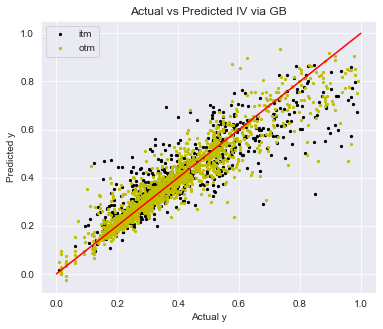

In [854]:
plotError(y_test,GB_y_predict,None,'GB')

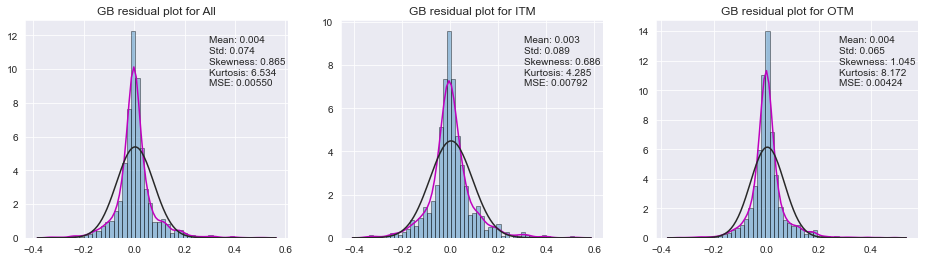

In [855]:
compare_residual(y_test,GB_y_predict,itm,otm,'ITM','OTM','GB')

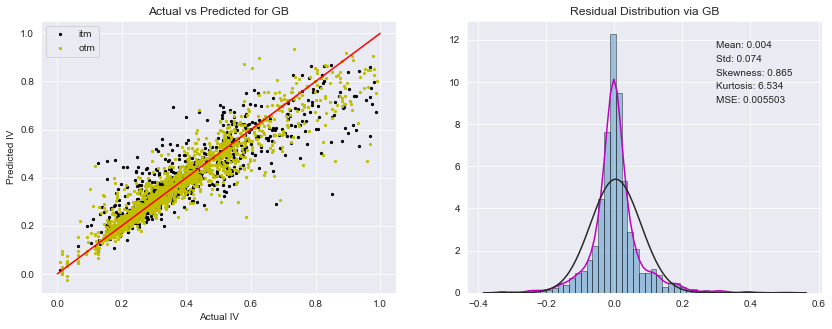

In [892]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].scatter(y_test[itm],GB_y_predict[itm],c='k',s=5,label='itm')
ax[0].scatter(y_test[otm],GB_y_predict[otm],c='y',s=5,label='otm')
ax[0].plot([0,1],[0,1],c='r')
ax[0].set(xlabel='Actual IV',ylabel='Predicted IV')
ax[0].set_title('Actual vs Predicted for {}'.format('GB'))
ax[0].legend()

residual = np.c_[y_test]-np.c_[GB_y_predict]
mse = np.mean(residual**2)
sns.distplot(residual,fit=norm,hist_kws={'edgecolor':'black'}, kde_kws={'color': 'm'},ax=ax[1])
ax[1].set_title('Residual Distribution via GB')
ax[1].text(0.7,0.9,'Mean: {:.3f}'.format(np.mean(residual)),transform=ax[1].transAxes)
ax[1].text(0.7,0.85,'Std: {:.3f}'.format(np.std(residual)),transform=ax[1].transAxes)
ax[1].text(0.7,0.8,'Skewness: {:.3f}'.format(skew(residual)[0]),transform=ax[1].transAxes)
ax[1].text(0.7,0.75,'Kurtosis: {:.3f}'.format(kurtosis(residual)[0]),transform=ax[1].transAxes)
ax[1].text(0.7,0.7,'MSE: {:.6f}'.format(mse),transform=ax[1].transAxes)
fig.savefig('residual scatter and dist for '+'GB'+'.png')

#### Tune KNN

In [722]:
from sklearn.neighbors import KNeighborsRegressor

In [729]:
#tune batch size, activation function, optimizer
n_neighbors = range(1, 21)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
param_grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
# define grid search
np.random.seed(42)
model = KNeighborsRegressor()
grid = GridSearchCV(estimator=model, param_grid=param_grid,scoring='neg_mean_squared_error',
                    n_jobs=4, cv=5, verbose=4)
grid_result_KNN = grid.fit(normed_x_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    8.4s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:   20.1s
[Parallel(n_jobs=4)]: Done 600 out of 600 | elapsed:   21.9s finished


In [730]:
grid_result_KNN.best_params_

{'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}

#### Test KNN

In [856]:
#test optimized KNN
def testKNN(x_train,y_train,x_test,y_test,subset='Total'):
    np.random.seed(42)
    KNN_model = KNeighborsRegressor(n_neighbors=4,weights='distance',metric='manhattan')
    KNN_model.fit(x_train,y_train)
    KNN_y_predict = KNN_model.predict(x_test)
    KNN_sq_err = (y_test-KNN_y_predict)**2 
    if subset == 'Total':
        KNN_mse = pd.Series({'Total_MSE':np.mean(KNN_sq_err),'ITM_MSE':np.mean(KNN_sq_err[itm]),
                             'OTM_MSE':np.mean(KNN_sq_err[otm])})
    else:
        KNN_mse = pd.Series({subset:np.mean(KNN_sq_err)})
    return KNN_mse, KNN_y_predict

In [857]:
KNN_mse, KNN_y_predict = testKNN(normed_x_train,y_train,normed_x_test,y_test)
print('KNN MSE: ',KNN_mse)

KNN MSE:  Total_MSE    0.009813
ITM_MSE      0.013533
OTM_MSE      0.007874
dtype: float64


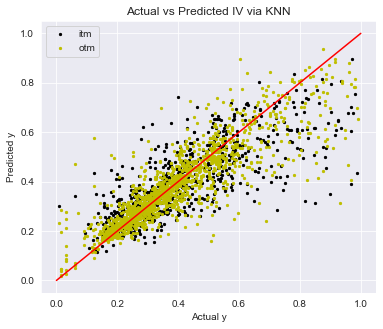

In [858]:
plotError(y_test,KNN_y_predict,None,'KNN')

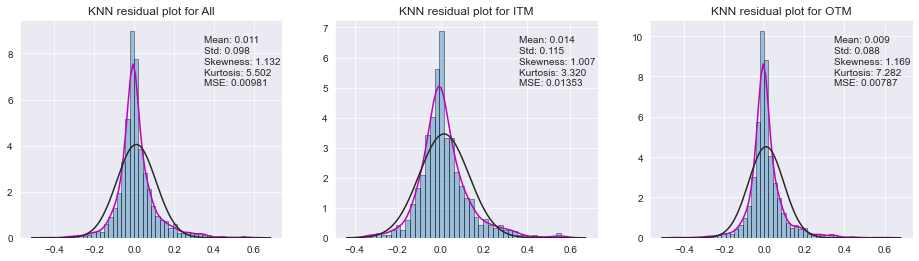

In [859]:
compare_residual(y_test,KNN_y_predict,itm,otm,'ITM','OTM','KNN')

#### Tune ERT

In [734]:
from sklearn.ensemble import ExtraTreesRegressor

In [761]:
#tune batch size, activation function, optimizer
n_estimators = [500,750,1000,1250,1500]
max_depth = range(20,40)
model = ExtraTreesRegressor(n_estimators=1250,random_state=42)
param_grid = dict(max_depth=max_depth)
grid = GridSearchCV(estimator=model, param_grid=param_grid,scoring='neg_mean_squared_error',
                    n_jobs=2, cv=5, verbose=2)
grid_result_ET = grid.fit(normed_x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  9.2min
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed: 25.3min finished


In [764]:
grid_result_ET.best_params_

{'max_depth': 30}

#### Test ERT

In [860]:
#test optimized ET
def testET(x_train,y_train,x_test,y_test,subset='Total'):
    ET_model = ExtraTreesRegressor(n_estimators=1250,max_depth=30,random_state=42)
    ET_model.fit(x_train,y_train)
    ET_y_predict = ET_model.predict(x_test)
    ET_sq_err = (y_test-ET_y_predict)**2 
    if subset == 'Total':
        ET_mse = pd.Series({'Total_MSE':np.mean(ET_sq_err),'ITM_MSE':np.mean(ET_sq_err[itm]),
                            'OTM_MSE':np.mean(ET_sq_err[otm])})
    else:
        ET_mse = pd.Series({subset:np.mean(ET_sq_err)})
    return ET_mse, ET_y_predict

In [861]:
ET_mse, ET_y_predict = testET(normed_x_train,y_train,normed_x_test,y_test)
print('ET MSE: ',ET_mse)

ET MSE:  Total_MSE    0.006390
ITM_MSE      0.008917
OTM_MSE      0.005072
dtype: float64


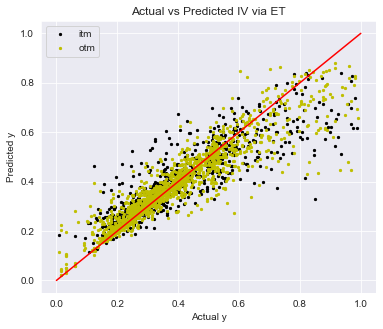

In [862]:
plotError(y_test,ET_y_predict,None,'ET')

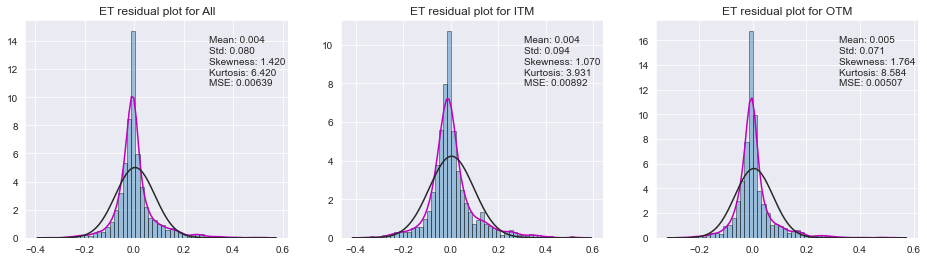

In [863]:
compare_residual(y_test,ET_y_predict,itm,otm,'ITM','OTM','ET')

In [864]:
total_mse = pd.DataFrame({'DNN':DNN_mse,'GB':GB_mse,'KNN':KNN_mse,'ET':ET_mse})
total_mse

,DNN,GB,KNN,ET
Total_MSE,0.008186,0.005503,0.009813,0.006390
ITM_MSE,0.010221,0.007924,0.013533,0.008917
OTM_MSE,0.007126,0.004241,0.007874,0.005072


# Part 3 Train model with only ITM/OTM data to see if there's improvements over mse

In [869]:
#create two datasets
itmData = option_data[itm]
otmData = option_data[otm]

#split two datasets
x_trainITM,x_testITM,y_trainITM,y_testITM = train_test_split(itmData.drop('Implied_volatility',axis=1),
                                                itmData['Implied_volatility'],test_size=0.2,random_state=42)
x_trainOTM,x_testOTM,y_trainOTM,y_testOTM = train_test_split(otmData.drop('Implied_volatility',axis=1),
                                                otmData['Implied_volatility'],test_size=0.2,random_state=42)
#normalize two datasets
scaler = StandardScaler()
normed_x_trainITM = scaler.fit_transform(x_trainITM)
normed_x_testITM = scaler.transform(x_testITM)

scaler = StandardScaler()
normed_x_trainOTM = scaler.fit_transform(x_trainOTM)
normed_x_testOTM = scaler.transform(x_testOTM)

In [870]:
DNN_mse_itm, DNN_history_itm, DNN_predict_itm = testDNN(normed_x_trainITM,y_trainITM,normed_x_testITM,y_testITM,subset='ITM')
DNN_mse_otm, DNN_history_otm, DNN_predict_otm = testDNN(normed_x_trainOTM,y_trainOTM,normed_x_testOTM,y_testOTM,subset='OTM')
print('DNN MSE for ITM data: ',DNN_mse_itm)
print('DNN MSE for OTM data: ',DNN_mse_otm)

DNN MSE for ITM data:  ITM    0.011997
dtype: float64
DNN MSE for OTM data:  OTM    0.00644
dtype: float64


In [871]:
GB_mse_itm, GB_y_predict_itm = testGB(normed_x_trainITM,y_trainITM,normed_x_testITM,y_testITM,subset='ITM')
GB_mse_otm, GB_y_predict_otm = testGB(normed_x_trainOTM,y_trainOTM,normed_x_testOTM,y_testOTM,subset='OTM')
print('GB MSE for ITM data: ',GB_mse_itm)
print('GB MSE for OTM data: ',GB_mse)

GB MSE for ITM data:  ITM    0.0084
dtype: float64
GB MSE for OTM data:  Total_MSE    0.005503
ITM_MSE      0.007924
OTM_MSE      0.004241
dtype: float64


In [872]:
KNN_mse_itm, KNN_y_predict_itm = testKNN(normed_x_trainITM,y_trainITM,normed_x_testITM,y_testITM,subset='ITM')
KNN_mse_otm, KNN_y_predict_otm = testKNN(normed_x_trainOTM,y_trainOTM,normed_x_testOTM,y_testOTM,subset='OTM')
print('KNN MSE for ITM data: ',KNN_mse_itm)
print('KNN MSE for OTM data: ',KNN_mse_otm)

KNN MSE for ITM data:  ITM    0.014292
dtype: float64
KNN MSE for OTM data:  OTM    0.007754
dtype: float64


In [873]:
ET_mse_itm, ET_y_predict_itm = testET(normed_x_trainITM,y_trainITM,normed_x_testITM,y_testITM,subset='ITM')
ET_mse_otm, ET_y_predict_otm = testET(normed_x_trainOTM,y_trainOTM,normed_x_testOTM,y_testOTM,subset='OTM')
print('ET MSE for ITM data: ',ET_mse_itm)
print('ET MSE for OTM data: ',ET_mse_otm)

ET MSE for ITM data:  ITM    0.009209
dtype: float64
ET MSE for OTM data:  OTM    0.004861
dtype: float64


In [874]:
itm_mse = pd.DataFrame({'DNN':DNN_mse_itm,'GB':GB_mse_itm,'KNN':KNN_mse_itm,'ET':ET_mse_itm})
otm_mse = pd.DataFrame({'DNN':DNN_mse_otm,'GB':GB_mse_otm,'KNN':KNN_mse_otm,'ET':ET_mse_otm})

In [877]:
pd.concat([itm_mse,otm_mse])

,DNN,GB,KNN,ET
ITM,0.011997,0.00840,0.014292,0.009209
OTM,0.006440,0.00368,0.007754,0.004861


In [878]:
total_mse

,DNN,GB,KNN,ET
Total_MSE,0.008186,0.005503,0.009813,0.006390
ITM_MSE,0.010221,0.007924,0.013533,0.008917
OTM_MSE,0.007126,0.004241,0.007874,0.005072
